[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/delta/blob/master/tutorial_notebooks/Tut9_Transformer_Sentiment_Analysis_Student.ipynb)

# Tutorial 9: Sentiment Analysis with Transformers

In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Create a global variable to idicate whether the notebook is run in Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

# Configure variables pointing to directories and stored files
if IN_COLAB:
    # Mount Google-Drive
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = '/content/drive/My Drive/ProDok/'  # adjust to Google drive folder with the data if applicable
else:
    DATA_DIR = './' # adjust to the directory where data is stored on your machine (if running the notebook locally)

sys.path.append(DATA_DIR)

CLEAN_REVIEW = DATA_DIR + 'imdb_clean_full_v2.pkl'   # List with tokenized reviews after standard NLP preparation

MessageError: Error: credential propagation was unsuccessful

In [2]:
CLEAN_REVIEW = 'imdb_clean_full_v2.pkl'

In [3]:
with open(CLEAN_REVIEW,'rb') as path_name:
    df = pd.read_pickle(path_name)

In [4]:
# Draw the same random sample of n reviews to increase the speed of the following steps and ensure comparability
n = 5000
np.random.seed(111)
ix = np.random.randint(0, high=df.shape[0]-1, size=n)
df = df.loc[ix, :]
df.reset_index(drop=True, inplace=True)

In [5]:
df.head()

,review,sentiment,review_clean
0,Started watching this but didn't believe in an...,negative,start watch believe character particular relat...
1,This totally UNfunny movie is so over the top ...,negative,totally unfunny movie top pathetic unrealistic...
2,There is absolutely nothing to redeem this mov...,negative,absolutely nothing redeem movie take sleazy st...
3,*****Warning: May contain SPOILERS********* My...,negative,warn may contain spoiler huge problem movie to...
4,It's not surprising that the majority of highe...,positive,surprising majority high rat vote submit femal...


## Task 1: Encode Sentiment and Perform Train-Test-Split

Transform the sentiment column, which consists of text at the momemt, into an appropriate numerical representation for further processing. Next, split the data into a train and test set.

In [8]:
# Encode the target variable
df['target']= df['sentiment'].map({'positive':1,'negative':0})
df.head()

,review,sentiment,review_clean,target
0,Started watching this but didn't believe in an...,negative,start watch believe character particular relat...,0
1,This totally UNfunny movie is so over the top ...,negative,totally unfunny movie top pathetic unrealistic...,0
2,There is absolutely nothing to redeem this mov...,negative,absolutely nothing redeem movie take sleazy st...,0
3,*****Warning: May contain SPOILERS********* My...,negative,warn may contain spoiler huge problem movie to...,0
4,It's not surprising that the majority of highe...,positive,surprising majority high rat vote submit femal...,1


In [9]:
# Train-test split
from sklearn.model_selection import train_test_split

column='review_clean'
# column='review'

X_train, X_test, y_train, y_test = train_test_split(df[column],
                                                    df['sentiment'],
                                                    test_size=0.25,
                                                    random_state=111)

## Task 2: Huggingface Pipelines

Transformer models are usually very large. With millions to tens of billions of parameters, training and deploying these models is a complicated undertaking. Furthermore, new models are being released more and more frequently and each one has its own implementation.

The French company Huggingface has set out to tackle that problem by developing a simple framwork to download and use fully pre-trained Transformer models for various usecases. Besides sentiment analysis those include image classification, speech recognition, text generation, translation and many more. A complete list can be found [here](https://huggingface.co/docs/transformers/main_classes/pipelines).

We will be using the sentiment analysis pipeline with the DistilBERT model, a distilled (reduced 40 % in size while maintaining 97 % of its performance) version of the BERT Transformer model, released by Google in 2018. Note that the pipeline automates several steps and obscures the fact that Transformers generally need a lot of code infrastructure and have many tunable parameters. We will show some of those steps in detail in the next part, where we finetune a Transformer model on our training data.

### Task: Initialize a huggingface pipeline with a model of your choice, try it out, and apply it to our test dataset.

Note: Huggingface requires tensorflow keras < 3.0.0, so depending on your Python version you might have to downgrade your tf-keras implementation.

In [10]:
!pip install transformers
# !pip install 'tf-keras<3.0.0'  # uncomment if you have problems with the version of tf-keras

In [11]:
from transformers import pipeline

In [12]:
classifier = pipeline('text-classification')

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


In [14]:
import torch

In [21]:
from transformers import pipeline

classifier = pipeline(
    task="text-classification",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    truncation = True
)

result = classifier("I love using Hugging Face Transformers!")
print(result)

Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9971315860748291}]


In [ ]:
classifier('I love this book.')

[{'label': 'POSITIVE', 'score': 0.9998767375946045}]

As you can see the pipeline outputs a classfication (POSITIVE or NEGATIVE) and a score that reflects its confidence. In order to evaluate the performace we'll need to extract the score for each movie review and put them into a list. That's what the function below will do.

Note that even though the model is already trained and we only generate predictions with it, the code might still take a couple minutes to run, since the huggingface pipelines are not very well optimized for GPU usage (as opposed to the regular huggingface models, which we will look at next). [Link](https://github.com/huggingface/transformers/issues/14125)

In [22]:
def pipeline_classify(data):
    ''' Function to run the sentiment analysis pipeline on each row of a dataset
    and extract the scores. '''

    scores = []
    for row in data:
      output = classifier(row)[0]
      score = output['score']
      label = output['label']
      score = score if label == 'POSITIVE' else -score
      scores.append(score)


In [23]:
predictions = pipeline_classify(X_test)

### Let's now take a look how well the model has performed.

Since we'll need to evaluate several models we define a function for assessing our predictions and plotting the ROC curve.

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

def assess_sentiment_classifier(ytest, yhat, cutoff=0.5, plot_roc=True):
    ''' Function to assess a classification model in terms of the AUC
    and classification accuracy. '''

    # Calculate discrete class predictions
    yhat_discrete = np.where(pd.DataFrame(yhat)>cutoff, 1, 0)
    # Calculate classification accuracy and AUC
    acc = accuracy_score(ytest, yhat_discrete)
    auc = roc_auc_score(ytest, yhat)
    # Confusion matrix
    cmat = confusion_matrix(ytest, yhat_discrete)
    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(ytest, yhat)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')
        plt.xlabel('False positive rate')
        plt.legend(loc='lower right')
        plt.show();

    print("NN test set performance:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))
    print('Confusion matrix:')
    print(cmat)

In [25]:
assess_sentiment_classifier(y_test, predictions)

ValueError: Found input variables with inconsistent numbers of samples: [1250, 0]

A solid performance for a model that hasn't previously seen our movie reviews at all. Let's see how much we can improve on this result by finetuning a model on the training data.

## Task 3: Finetuning a pretrained huggingface model

What we will do now is load a sequence classification model that has been pretrained on a large amount of english text and finetune it by further training it on our training data.

For the sake of speed and efficiency we will once again be using DistilBERT. For a list of models available through huggingface transformers visit their [docs](https://huggingface.co/docs/transformers/v4.18.0/en/model_doc/auto).

In the first step we need to tokenize the inputs. For that we need to utilize the right tokenizer for the model we'll be using. Huggingface makes this step easy with the AutoTokenizer class. All we need to do is specify the pretrained model vocabulary and the according tokenizer is selected automatically. We will be downloading the vocabulary of 30,522 words that belongs to the DistilBert Base Uncased model.

In [ ]:
!pip install 'accelerate>=0.26.0'

In [ ]:
# Load DistilBert tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
tokenizer('I need a new GPU!')

{'input_ids': [101, 1045, 2342, 1037, 2047, 14246, 2226, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# tokenize training reviews
X_tr_int_pad = tokenizer(X_train.tolist(), truncation=True, padding='max_length')

Since the huggingface trainer only takes torch datasets as input, we need to transform our training dataset into a torch dataset and specify the labels.

In [ ]:
# create a torch dataset for training
import torch

class IMDB_Dataset(torch.utils.data.Dataset):
    def __init__(self, reviews, sentiments):
        self.reviews = reviews
        self.sentiments = sentiments

    def __len__(self):
        return len(self.sentiments)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.reviews.items()}
        item['labels'] = torch.tensor(self.sentiments[idx])
        return item

train_dataset = IMDB_Dataset(X_tr_int_pad, y_train.tolist())

Next we load the DistilBert Base Uncased model. We need to specify how many unique labels we have, i.e. how many classes the model is supposed to classify into. Furthermore we need to specifically tell the model to utlize the GPU if one is available.

In [ ]:
# load DistilBert model along with the number of expected labels
...

In [ ]:
# set model to use gpu if possible
if torch.backends.cuda.is_built() and torch.cuda.is_available():
    device = torch.device('cuda') # for NVIDIA GPUs
elif torch.backends.mps.is_built():
    device = torch.device('mps') # for Apple Silicon Macs
else:
    device = torch.device('cpu')

model.to(device)

Now we import the Trainer and set the hyperparameters for the training process:

- num_train_epochs: Number of passes through the entire training dataset (epochs).
- per_device_train_batch_size: Number of training samples that will be propagated through the network by each GPU core / CPU in each step (the smaller the faster the network trains but the fuzzier the results; the larger the more memory you'll need).
- learning_rate: Parameter that controls how much the model is changed each time the weights are updated, i.e. how large steps the trainer takes towards minimzing loss (too low and the training might get stuck in a local minimum, to large and it might be too unstable and never reach any minimum).
- warmup_steps: Number of steps used for a linear warmup from 0 to the set learning rate.
- weight_decay: Regularization parameter – penalty for too large weights (too high and the model doesn't fit well, too low and the model will be prone to overfit).

The optimal parameter configuration will vary based on the type and size of your training dataset. Tuning them to get the best training result is a task of its own.

In [ ]:
# load trainer and set arguments for training
...

It's time to train. This may take a couple of minutes. You can reduce the number of epochs or the batch size to speed up the process.

In [ ]:
# fine-tune the model on the train data
...

Now that the model is trained we can compute the predictions on the test dataset. For that we'll need a function to extract the output from the model.

In [ ]:
from tensorflow.nn import softmax

def DistilBert_classify(data):
    ''' Function to run a finetuned huggingface model on each row of a dataset
    and extract the scores. '''

    ...

In [ ]:
predictions = DistilBert_classify(X_test)

In [ ]:
# assess sentiment classification model
...

That's a much better result than we were able to achieve with the pipeline or any other deep neural network before.

## A note on transfer learning

Transfer learning is the technique of training a model to do one task and then use it to do another. In our case we used the pipeline model, that was pretrained on natural text and used it to predict sentiments on highly preprocessed movie reviews. Let's see how the pipeline performs on the raw movie review data.

In [ ]:
# perform train-test split with raw data
column='review'

X_train, X_test, y_train, y_test = train_test_split(df[column],
                                                    df['sentiment'],
                                                    test_size=0.25,
                                                    random_state=111)

In [ ]:
# generate predictions
predictions = pipeline_classify(X_test)

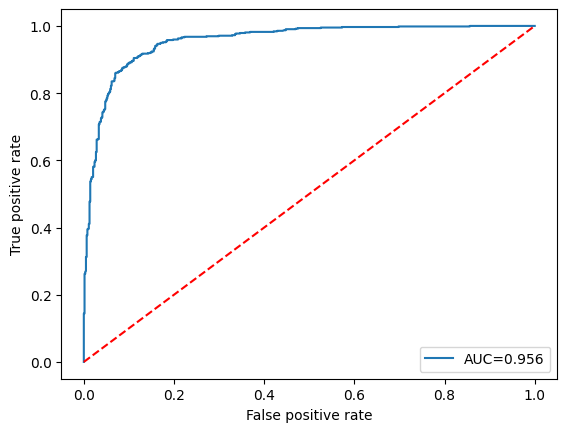

NN test set performance:	AUC=0.9560	Accuracy=0.8928
Confusion matrix:
[[580  52]
 [ 82 536]]


In [ ]:
# evaluate the results
assess_sentiment_classifier(y_test, predictions)

As opposed to our previous models, the performance of the pipeline is much better on the raw data. Since the model is trained on natural text and has a much higher level of complexity than our previous neural network architectures it is able to extract information well from coherent sentences. In this case removing stop words and punctuation therefore constituted a loss of information.

If you like, you can also go ahead and finetune the DistilBert model on the raw data as an exercise and see how much of an improvement you're going to get there.